In [1]:
import torch
import math
import copy
import time

from sklearn.model_selection import StratifiedKFold, KFold
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np

torch.set_printoptions(precision=8)
torch.manual_seed(32)

root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

In [2]:
from src.timeseries_transformer.datasets import DatasetBuilder

In [9]:
db = DatasetBuilder(split="train", use_k_fold=True, num_folds=2)

In [10]:
db.shape

(64, 500, 1)

In [11]:
ds = db.get_dataset()

In [12]:
db_test = DatasetBuilder(split="test")

In [13]:
test_dataset = db_test.get_dataset()

In [168]:
class FordDatasetKfold(Dataset):
  def __init__(self, sequences, labels):
    self.labels = labels
    self.sequences = sequences
    self.num_classes = len(torch.unique(self.labels)) # count the number of unique labels

  def __len__(self):
      return self.sequences.shape[0]

  def __getitem__(self, idx):
    sequence = torch.reshape(self.sequences[idx], (-1, 1)) # dim: seq_len x num_features
    label = torch.reshape(self.labels[idx], (-1, )) # dim: 1 x 1

    return sequence, label

In [169]:
class FordDataset(Dataset):
  def __init__(self, split="train"):
    self.root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"
    self.data = torch.tensor(np.loadtxt(self.root_url + "FordA_TRAIN.tsv", delimiter="\t"), dtype=torch.float32) if split=="train" else torch.tensor(np.loadtxt(self.root_url + "FordA_TEST.tsv", delimiter="\t"), dtype=torch.float32)
    self.labels = self.data[:, 0] # get first element from each example
    self.sequences = self.data[:, 1:] # get all elements after first element
    self.labels[self.labels == -1] = 0 # change all -1 labels to 0
    self.num_classes = len(torch.unique(self.labels)) # count the number of unique labels

  def __len__(self):
      return self.data.shape[0]

  def __getitem__(self, idx):
    sequence = torch.reshape(self.sequences[idx], (-1, 1)) # dim: seq_len x num_features
    label = torch.reshape(self.labels[idx], (-1, )) # dim: 1 x 1

    return sequence, label

test_dataset = FordDataset("test")

In [170]:
train_data = torch.tensor(np.loadtxt(root_url + "FordA_TRAIN.tsv", delimiter="\t"), dtype=torch.float32)

In [171]:
train_data.shape

torch.Size([3601, 501])

In [172]:
y = train_data[:, 0]

In [173]:
y[y == -1] = 0

In [174]:
x = train_data[:, 1:] # get all elements after first element

In [175]:
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=32)

In [176]:
x.shape

torch.Size([3601, 500])

In [177]:
y.shape

torch.Size([3601])

In [8]:
train_sets = []
val_sets = []

In [9]:
ds

{'train': [<src.timeseries_transformer.datasets.FordDataset at 0x73de67915190>,
 'val': [<src.timeseries_transformer.datasets.FordDataset at 0x73de67914560>,
  <src.timeseries_transformer.datasets.FordDataset at 0x73de697cfbc0>]}

In [11]:
train_sets = ds["train"]
val_sets = ds["val"]

In [179]:
for train_idx, val_idx in skf.split(x, y):
    # Create PyTorch DataLoader for training and validation
    train_sets.append(FordDatasetKfold(x[train_idx], y[train_idx]))
    val_sets.append(FordDatasetKfold(x[val_idx], y[val_idx]))
    

In [180]:
train_sets

In [14]:
embed_size=256 # size of the embeddings
num_heads=4 # number of attention heads
ff_dim=4 # dimension of the feedforward layer in the encoder
num_transformer_blocks=2 # number of encoder blocks
mlp_units=[128] # the size of the feedforward layer used to make predictions
mlp_dropout=0.4 # dropout in the feedforward layer
dropout=0.25 # dropout in the encoder

In [15]:
def clones(module, N):
    "Produce N independent but identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [16]:
train_dataloaders, val_dataloaders = db.create_dataloader(batch_size=64, shuffle=True, drop_last=True)
test_dataloader = db_test.create_dataloader(batch_size=64, drop_last=True)
len(train_dataloaders)

2

In [12]:
train_dataloaders = [DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, drop_last = True) for train_dataset in train_sets]
val_dataloaders = [DataLoader(dataset=val_dataset, batch_size=64, shuffle=True, drop_last = True) for val_dataset in val_sets]
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True, drop_last = True)
len(train_dataloaders)

2

In [25]:
x,y = next(iter(train_dataloaders[0]))
xp = x

print(xp.shape)
print(xp[0][0:3])

torch.Size([64, 500, 1])
tensor([[0.83923525],
        [0.70060378],
        [0.47375235]])


In [17]:
class PtMultiheadAttention(nn.Module):
  def __init__(self, head_size, num_heads, dropout=0.1):
    super(PtMultiheadAttention, self).__init__()
    assert head_size % num_heads == 0

    self.d_k = head_size // num_heads
    self.weight_matrices = clones(nn.Linear(head_size, head_size), 4)
    self.attn = None
    if dropout > 0:
      self.dropout = nn.Dropout(dropout)

  def _attention(self, query, key, value, mask=None, dropout=None):
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.d_k)
    # if mask is not None:
    #   scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = scores.softmax(dim=-1)
    # if dropout is not None:
    #   p_attn = self.dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

  def forward(self, query, key, value):

    # get q, k and v
    query, key, value = [
      weights(inputs)
      for weights, inputs in zip(self.weight_matrices, (query, key, value))
    ]

    # calculate attention
    x, self.attn = self._attention(query, key, value)

    return self.weight_matrices[-1](x)

In [18]:
class PytorchEncoder(nn.Module):
  def __init__(self, inputs, embed_size, num_heads, ff_dim, dropout=0):
    super(PytorchEncoder, self).__init__()
    # attention
    self.embedding = nn.Linear(in_features=inputs.shape[-1], out_features=embed_size)
    self.attention = PtMultiheadAttention(embed_size, num_heads, dropout=0.0)
    self.linear1 = nn.Linear(embed_size, 1)
    self.dropout1 = nn.Dropout(dropout)
    self.layer_norm1 = nn.LayerNorm(normalized_shape=inputs.shape[-1], eps=1e-6)

    # feedforward
    self.conv1 = nn.Conv1d(in_channels=inputs.shape[-1], out_channels=ff_dim, kernel_size=1)
    self.relu1 = nn.ReLU()
    self.dropout2 = nn.Dropout(dropout)
    self.conv2 = nn.Conv1d(in_channels=ff_dim, out_channels=inputs.shape[-1], kernel_size=1)
    self.layer_norm2 = nn.LayerNorm(normalized_shape=inputs.shape[1], eps=1e-6)


  def forward(self, src):
    x = self.embedding(src)
    x = self.attention(x, x, x)[0]
    x = self.linear1(x)
    x = self.dropout1(x)
    x = self.layer_norm1(x)

    res = x + src
    res = res.reshape(res.shape[0], res.shape[2], res.shape[1])

    x = self.conv1(res)
    x = self.relu1(x)
    x = self.dropout2(x)
    x = self.conv2(x)
    x = self.layer_norm2(x)
    x = x + res

    return x.reshape(x.shape[0], x.shape[-1], x.shape[1])

In [19]:
from collections import OrderedDict

class EncoderClassifier(nn.Module):
  def __init__(self, inputs, embed_size, num_heads, ff_dim, dropout=0, num_blocks=2):
    super(EncoderClassifier, self).__init__()
    encoder_layer = PytorchEncoder(inputs=inputs, embed_size=embed_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)
    encoders = OrderedDict()
    for idx in range(num_blocks):
      encoders[f"encoder{idx}"] = encoder_layer
    self.encoder_block = nn.Sequential(encoders)
    self.avg = nn.AvgPool1d(kernel_size=1)
    self.dense1 = nn.Linear(500, mlp_units[0])
    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(dropout)
    self.dense2 = nn.Linear(mlp_units[0], 2)
    self.softmax = nn.Softmax()

  def forward(self, x):
    x = self.encoder_block(x)
    x = torch.squeeze(self.avg(x), 2)
    x = self.dense1(x)
    x = self.relu1(x)
    x = self.dropout1(x)
    x = self.dense2(x)
    x = self.softmax(x)
    return x

In [20]:
# temporal convolutional nn
cuda0 = torch.device('cuda:0')
# model = EncoderClassifier(inputs=xp, embed_size=embed_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)
# model.cuda()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [21]:
def train_one_epoch(epoch_index, train_data, val_data, model):
    train_running_loss = 0.
    train_last_loss = 0.
    train_correct = 0
    iterations = 0
    
    for i, (inputs,labels) in enumerate(train_data):
      if torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
          
      model["opt"].zero_grad()
      outputs = model["model"](inputs)
      loss = model["loss_fn"](outputs, labels.to(torch.long).reshape(-1))
      loss.backward()
      model["opt"].step()
      train_running_loss += loss.item()

      predictions = torch.argmax(outputs, axis=1)
      correct_labels = labels.squeeze()

      train_correct += (predictions == correct_labels).int().sum()/len(labels) * 100
      iterations += 1
    train_last_loss = train_running_loss / len(train_data)
    train_acc = (train_correct / iterations)
    
    
    
    val_running_loss = 0.
    val_last_loss = 0.
    val_correct = 0
    
    iterations = 0
    model["model"].eval()
    for i, (inputs,labels) in enumerate(val_data):
      if torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
      outputs = model["model"](inputs)
      loss = model["loss_fn"](outputs, labels.to(torch.long).reshape(-1))
      val_running_loss += loss.item()

      predictions = torch.argmax(outputs, axis=1)
      correct_labels = labels.squeeze()

      val_correct += (predictions == correct_labels).int().sum()/len(labels) * 100
      iterations += 1
    val_last_loss = val_running_loss / len(val_data)
    val_acc = (val_correct / iterations)

    return train_last_loss, train_acc, val_last_loss, val_acc

In [32]:
epochs = 20
models = []
losses = []
accuracies = []
for fold in range(len(train_dataloaders)):
  print('FOLD {}:'.format(fold + 1))
  
  train_dataloader = train_dataloaders[fold]
  val_dataloader = val_dataloaders[fold]
  
  model = EncoderClassifier(inputs=xp, embed_size=embed_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, num_blocks=num_transformer_blocks)
  model.cuda()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  models.append({"model": model, "loss_fn": criterion, "opt": optimizer})
  
  losses.append([])
  accuracies.append([])
  
  for epoch in range(epochs):
      print('EPOCH {}:'.format(epoch + 1))
  
      models[fold]["model"].train(True)
      train_avg_loss, train_acc, val_avg_loss, val_acc = train_one_epoch(epoch, train_dataloader, val_dataloader, models[fold])
  
      print(train_avg_loss)
      print(train_acc)
      print(val_avg_loss)
      print(val_acc)
      
      losses[fold].append((train_avg_loss, val_avg_loss))
      accuracies[fold].append((train_acc, val_acc))

FOLD 1:
EPOCH 1:
0.6965559844312996
tensor(50.80818939, device='cuda:0')
0.7018395477327807
tensor(48.61709976, device='cuda:0')
EPOCH 2:
0.675064362328628
tensor(57.32758713, device='cuda:0')
0.7046850919723511
tensor(51.16139603, device='cuda:0')
EPOCH 3:
0.6542072809975723
tensor(61.20689774, device='cuda:0')
0.7099324177051413
tensor(51.84985733, device='cuda:0')
EPOCH 4:
0.6372402680331263
tensor(64.38577271, device='cuda:0')
0.7073359756634153
tensor(53.63386154, device='cuda:0')
EPOCH 5:
0.6105192057017622
tensor(68.10344696, device='cuda:0')
0.6981730646100538
tensor(55.96863174, device='cuda:0')
EPOCH 6:
0.5832463893397101
tensor(72.57543182, device='cuda:0')
0.6967815654031162
tensor(56.54334259, device='cuda:0')
EPOCH 7:
0.5502950836872232
tensor(75.59267426, device='cuda:0')
0.6798300064843277
tensor(59.08764267, device='cuda:0')
EPOCH 8:
0.5108491870863684
tensor(82.00431061, device='cuda:0')
0.6618770073200094
tensor(59.41690826, device='cuda:0')
EPOCH 9:
0.50021538652222

In [33]:
acc = 0
iteration = 0
for data in test_dataloader:
  iteration += 1
  inputs, labels = data
  if torch.cuda.is_available():
    inputs = inputs.cuda()
    labels = labels.cuda()
  outputs = models[0]["model"](inputs)
  predictions = torch.argmax(outputs, axis=1)
  correct_labels = labels.squeeze().int()

  acc += (predictions == correct_labels).int().sum()/len(labels) * 100
print(acc/iteration)

tensor(63.64583588, device='cuda:0')


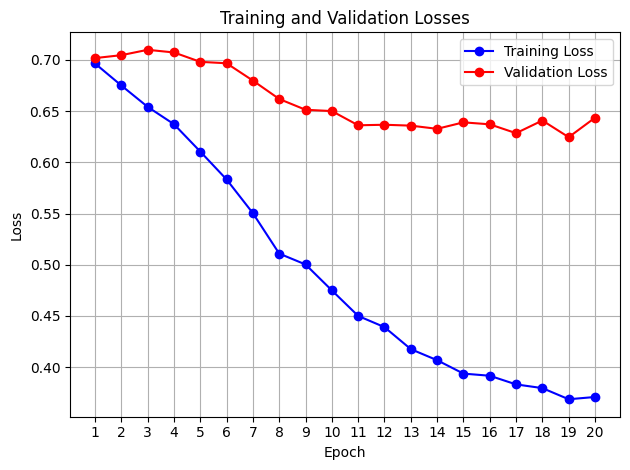

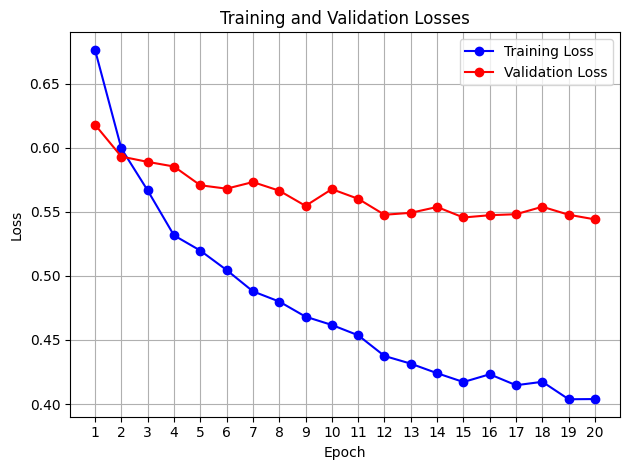

In [34]:
for loss in losses:
  # Extracting training losses
  train_losses = [t[0] for t in loss]
  val_losses = [t[1] for t in loss]
  
  # Creating index for x-axis
  indices = range(1, len(loss) + 1)

  plt.plot(indices, train_losses, marker='o', linestyle='-', color='b', label='Training Loss')
  plt.plot(indices, val_losses, marker='o', linestyle='-', color='r', label='Validation Loss')

  plt.title('Training and Validation Losses')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.xticks(indices)
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

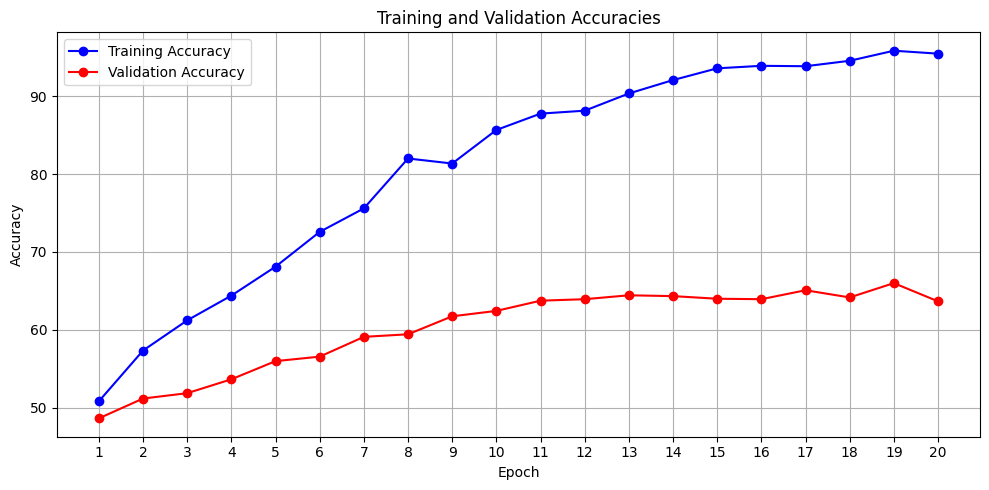

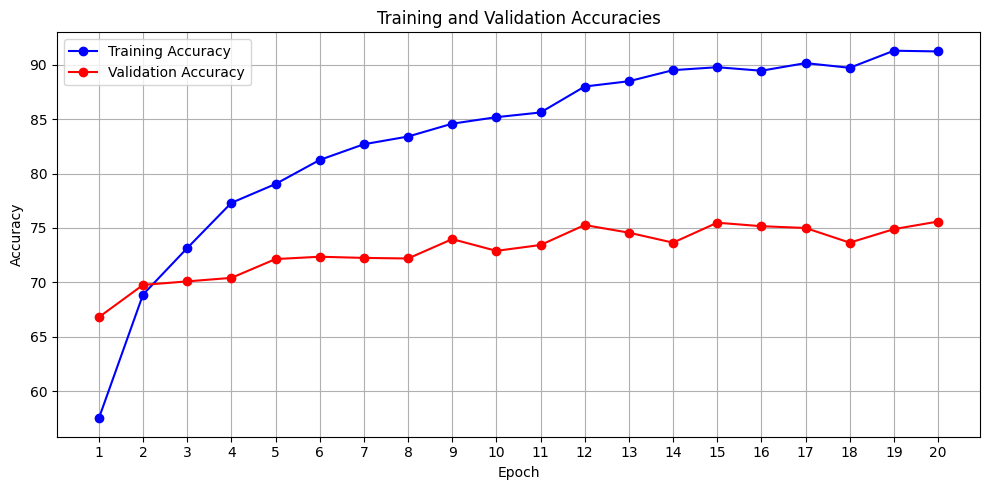

In [35]:
# Extracting training losses
for accuracy in accuracies:
  train_accs = [t[0].cpu() for t in accuracy]
  val_accs = [t[1].cpu() for t in accuracy]
  
  # Creating index for x-axis
  indices = range(1, len(accuracy) + 1)
  
  # Plotting
  plt.figure(figsize=(10, 5))
  plt.plot(indices, train_accs, marker='o', linestyle='-', color='b', label='Training Accuracy')
  plt.plot(indices, val_accs, marker='o', linestyle='-', color='r', label='Validation Accuracy')
  plt.title('Training and Validation Accuracies')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.xticks(indices)
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()